## Crop Classification

#### Visualization of spation temporal input and expected outputs for crop type prediction models

In [1]:
# cd stelar_3d/
# 

#virtualenv -p python3.10 ttenv
#
#source ttenv/bin/activate
#

# Crop type prediction Using 3d Unet

In [11]:
import tensorflow as tf
import keras
import tifffile

print(tf.__version__)
print(keras.__version__)

import numpy as np

2.13.1
2.13.1


In [12]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()

2024-07-01 17:14:58.393778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 17:14:58.397777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 17:14:58.400252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-07-01 17:14:58.530078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 17:14:58.531752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 17:14:58.533499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

## Vista Crop Types

In [97]:

vista_crop_dict = { 0:'NA' , 1: 'ALFALFA', 2: 'BEET', 3: 'CLOVER', 4: 'FLAX', 5: 'FLOWERING_LEGUMES', 6: 'FLOWERS', 7: 'FOREST', 8: 'GRAIN_MAIZE', 9: 'GRASSLAND', 10: 'HOPS', 11: 'LEGUMES', 12: 'NA', 13: 'PERMANENT_PLANTATIONS', 14: 'PLASTIC', 15: 'POTATO', 16: 'PUMPKIN', 17: 'RICE', 18: 'SILAGE_MAIZE', 19: 'SOY', 20: 'SPRING_BARLEY', 21: 'SPRING_OAT', 22: 'SPRING_OTHER_CEREALS', 23: 'SPRING_RAPESEED', 24: 'SPRING_RYE', 25: 'SPRING_SORGHUM', 26: 'SPRING_SPELT', 27: 'SPRING_TRITICALE', 28: 'SPRING_WHEAT', 29: 'SUGARBEET', 30: 'SUNFLOWER', 31: 'SWEET_POTATOES', 32: 'TEMPORARY_GRASSLAND', 33: 'WINTER_BARLEY', 34: 'WINTER_OAT', 35: 'WINTER_OTHER_CEREALS', 36: 'WINTER_RAPESEED', 37: 'WINTER_RYE', 38: 'WINTER_SORGHUM', 39: 'WINTER_SPELT', 40: 'WINTER_TRITICALE', 41: 'WINTER_WHEAT'}

labels = np.load('/home/luser/stelar_3d/storage/full_mast/vista_labes_aligned.npy').astype(np.uint8)

In [58]:
# step of simplifying and saving as tiff file as uint8

'''vis1 = io.imread('/home/luser/stelar_3d/storage/first64/50to64.tif') # loaded one after the other and converted and saved as uint8
unique_elements, element_counts = np.unique(labels, return_counts=True)
all_input_img = 0
all_input_mask = 0

lai_uniques = np.unique(vis1)

for n in range(len(lai_uniques)):
  vis1[vis1==lai_uniques[n]]=n
vis1 = vis1.astype(np.uint8)

tifffile.imsave('/home/luser/stelar_3d/storage/first64/processed/50to64.tif', vis1)
'''

In [103]:
#Important Functions
def slice_and_stack_cubes(data, cube_size=64):
    z_dim, x_dim, y_dim = data.shape
    cubes = []

    # Iterate through the spatial dimensions in steps of cube_size
    for x in range(0, x_dim, cube_size):
        for y in range(0, y_dim, cube_size):
            # Check if the sub-cube fits within the boundaries
            if x + cube_size <= x_dim and y + cube_size <= y_dim:
                cube = data[:, x:x + cube_size, y:y + cube_size]
                cubes.append(cube)

    # Stack the collected cubes into a new array
    cubes_array = np.stack(cubes)
    return cubes_array

def reassemble_cubes(cubes, original_shape, cube_size=64):
    z_dim, x_dim, y_dim = original_shape
    reassembled = np.zeros((z_dim, x_dim, y_dim))

    index = 0
    for x in range(0, x_dim, cube_size):
        for y in range(0, y_dim, cube_size):
            if x + cube_size <= x_dim and y + cube_size <= y_dim:
                reassembled[:, x:x + cube_size, y:y + cube_size] = cubes[index]
                index += 1

    return reassembled

def reassemble_2d_slices(slices, original_shape, slice_size=64):
    x_dim, y_dim = original_shape
    reassembled = np.zeros((x_dim, y_dim))

    index = 0
    for x in range(0, x_dim, slice_size):
        for y in range(0, y_dim, slice_size):
            if x + slice_size <= x_dim and y + slice_size <= y_dim:
                reassembled[x:x + slice_size, y:y + slice_size] = slices[index]
                index += 1

    return reassembled


def slice_2d_labels(labels, slice_size=64):
    x_dim, y_dim = labels.shape
    slices = []

    # Iterate through the spatial dimensions in steps of slice_size
    for x in range(0, x_dim, slice_size):
        for y in range(0, y_dim, slice_size):
            # Check if the sub-slice fits within the boundaries
            if x + slice_size <= x_dim and y + slice_size <= y_dim:
                slice = labels[x:x + slice_size, y:y + slice_size]
                slices.append(slice)

    # Stack the collected slices into a new array
    slices_array = np.stack(slices)
    return slices_array

In [67]:
# loading all processed data and concatenating 

vispro1 = io.imread('/home/luser/stelar_3d/storage/first64/processed/first25.tif')
vispro2 = io.imread('/home/luser/stelar_3d/storage/first64/processed/25to50.tif')
vispro3 = io.imread('/home/luser/stelar_3d/storage/first64/processed/50to64.tif')

all_processed_LAI = np.concatenate([vispro1, vispro2, vispro3])

# Sice the spatio temporal image of 64, 10002, 10002 into bunch of cubes of 64, 64, 64

In [112]:
# Execute the function
sliced_cubes = slice_and_stack_cubes(all_processed_LAI)

# Output the shape of the resulting array
print(sliced_cubes.shape)


(24336, 64, 64, 64)


# Slice the labels to form same number of 2d planes

In [113]:

sliced_labels = slice_2d_labels(labels)

print(sliced_labels.shape)


(24336, 64, 64)


# Next steps

In [114]:
input_img = sliced_cubes
input_mask = sliced_labels
input_mask = np.repeat(input_mask[:, np.newaxis, :, :], repeats=64, axis=1)

sliced_cubes = 0
sliced_labels = 0

print(input_img.shape, input_mask.shape)

(24336, 64, 64, 64) (24336, 64, 64, 64)


In [ ]:
n_classes = 4

In [120]:
input_mask_1 = input_mask.copy()
input_mask_2 = input_mask.copy()
input_mask_3 = input_mask.copy()


input_mask_1[input_mask_1<11]=0
input_mask_1[(input_mask_1>13) & (input_mask_1<32)]=0
input_mask_1[(input_mask_1>11) & (input_mask_1<13)]=0
input_mask_1[input_mask_1>32]=0
input_mask_1[input_mask_1==11]=1
input_mask_1[input_mask_1==13]=2
input_mask_1[input_mask_1==32]=3



X_test = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask_1, axis=4)
y_test_1 = to_categorical(train_mask, num_classes=n_classes)
#X_train, X_test, y_train, y_test_1 = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)



input_mask_2[input_mask_2<9]=0
input_mask_2[(input_mask_2>9) & (input_mask_2<11)]=0
input_mask_2[(input_mask_2>11) & (input_mask_2<13)]=0
input_mask_2[input_mask_2>13]=0
input_mask_2[input_mask_2==9]=1
input_mask_2[input_mask_2==11]=2
input_mask_2[input_mask_2==13]=3


#X_test = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask_2, axis=4)
y_test_2 = to_categorical(train_mask, num_classes=n_classes)
#X_train, X_test, y_train, y_test_2 = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)


input_mask_3[input_mask_3<1]=0
input_mask_3[(input_mask_3>1) & (input_mask_3<7)]=0
input_mask_3[(input_mask_3>8)]=0
input_mask_3[input_mask_3==1]=1
input_mask_3[input_mask_3==7]=2
input_mask_3[input_mask_3==8]=3

#X_test = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask_3, axis=4)
y_test_3 = to_categorical(train_mask, num_classes=n_classes)
#X_train, X_test, y_train, y_test_3 = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)




: 

: 

: 

In [ ]:
# emptying space 
train_img = 0
train_mask_cat = 0
train_mask = 0
input_mask_1 = 0
input_mask_2 = 0
input_mask_3 = 0

input_img = 0

X_train = 0
y_train = 0

In [ ]:
X_test.shape, y_test_1.shape, y_test_3.shape

In [ ]:
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50

#BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50

In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)

# Loading of trained models

In [ ]:

from keras.models import load_model

my_model_1 = load_model('/home/luser/stelar_3d/storage/saved_model/3D_unet_labels_'+vista_crop_dict[0]+'_'+vista_crop_dict[11]+'_'+vista_crop_dict[13]+'_'+vista_crop_dict[32]+'_num_epocs_'+str(num_epochs)+'.h5', compile=False)
my_model_2 = load_model('/home/luser/stelar_3d/storage/saved_model/3D_unet_labels_'+vista_crop_dict[0]+'_'+vista_crop_dict[9]+'_'+vista_crop_dict[11]+'_'+vista_crop_dict[13]+'_num_epocs_'+str(num_epochs)+'.h5', compile=False)
my_model_3 = load_model('/home/luser/stelar_3d/storage/saved_model/3D_unet_labels_'+vista_crop_dict[0]+'_'+vista_crop_dict[1]+'_'+vista_crop_dict[7]+'_'+vista_crop_dict[8]+'_num_epocs_'+str(num_epochs)+'.h5', compile=False)



In [ ]:
def get_labels_in_color(groud_truth_image):
    color_map = {
        0: [0, 0, 0],1: [0, 255, 0], 2: [0, 0, 255], 3: [255, 255, 0], 4: [255, 165, 0], 5: [255, 0, 255], 6: [0, 255, 255],   
        7: [128, 0, 128], 8: [128, 128, 0], 9: [0, 128, 0], 10: [128, 0, 0], 11: [0, 0, 128], 12: [128, 128, 128], 13: [0, 128, 128],   
        14: [255, 0, 0], 15: [255, 255, 255], 16: [192, 192, 192], 17: [255, 0, 0], 18: [0, 255, 0], 19: [0, 0, 255], 20: [255, 255, 0],   
        21: [255, 165, 0], 22: [255, 0, 255],  23: [0, 255, 255],  24: [128, 0, 128],  25: [128, 128, 0],  26: [0, 128, 0],     
        27: [128, 0, 0],  28: [0, 0, 128], 29: [128, 128, 128], 30: [0, 128, 128], 31: [0, 0, 0], 32: [255, 255, 255], 
        33: [192, 192, 192], 34: [255, 0, 0], 35: [0, 255, 0], 36: [0, 0, 255], 37: [255, 255, 0], 38: [255, 165, 0], 
        39: [255, 0, 255],  40: [0, 128, 255] }
    groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
    for i in range(groud_truth_image.shape[0]):
        for j in range(groud_truth_image.shape[1]):
            segment_id_gt = groud_truth_image[i, j]
            groud_truth_color_image[i, j] = color_map[segment_id_gt]
    return groud_truth_color_image

# Assemble back all the sliced cubes to original form

In [102]:
original_shape = (64, 10002, 10002)
reassembled_array = reassemble_cubes(sliced_cubes, original_shape)
print(reassembled_array.shape)


(64, 10002, 10002)


In [83]:
#getting back to original form from flattended 3d slices to 2d back to image form, this is useful for labels

flattened = sliced_cubes[:, 0, :, :]

In [84]:
flattened.shape

(24336, 64, 64)

In [85]:


# Assuming the original shape was (10002, 10002)
original_shape = (10002, 10002)

# Example slices for illustration (replace with actual data)
#slices = np.random.rand(24336, 64, 64)

# Execute the function to reassemble the 2D slices
reassembled_image = reassemble_2d_slices(flattened, original_shape)

# Output the shape of the reassembled array to verify
print(reassembled_image.shape)


(10002, 10002)


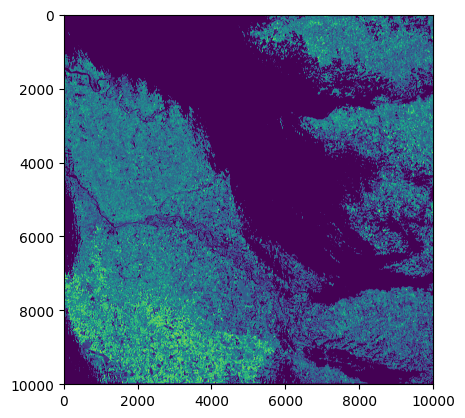

In [86]:
plt.imshow(reassembled_image)

(24336, 64, 64)


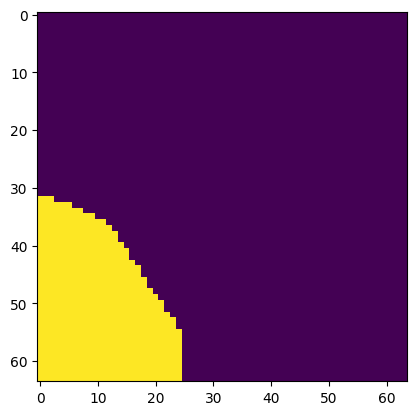

In [92]:
plt.imshow(sliced_labels[1000, :, :])

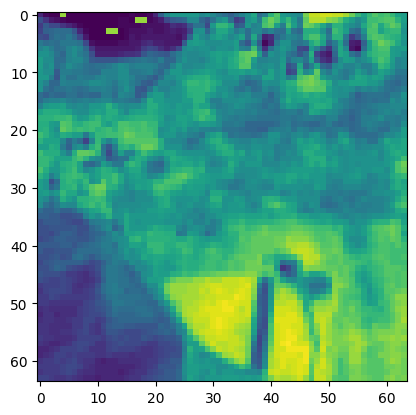

In [93]:
plt.imshow(sliced_cubes[1000, 13, :, :])

In [94]:
# clear memory 
lai_uniques = 0

In [95]:
n_classes=4

# Loading of the test set